# Heteroscedastic Regression

### by Ricardo Andrade
#### editted by Alan Saul - updated on 7th November 2017

In vanilla Gaussian process regression, the generative model assumes that there is an underlying latent function of interest, and that observations that have been made are some Gaussian corruption of this underlying latent function.

Crucially the standard assumption is that the noise variance of the Gaussian likelihood (the observation error variance) is the same for all input observations. In some applications there is *some* existing knowledge as to how much variance there is around each observation, it may vary for each output, or both of these cases.

In this notebook we will look at how to implement a GP regression with different noise terms using GPy, this is known as "heteroscedastic Gaussian process regression" as opposed to the standard "homoscedastic Gaussian process regression" where the variance is shared amongst all obserations.

$\bf N.B.:$ There is currently no implementation to predict the noise for outputs that are not part of the training set, as such the variance must be known on output points as well.

More formally, usually a GP regression model assumes that a set of targets $\{ y_1,\ldots,y_n \}$ is related to a set of inputs $\{ {\bf x }_1,\ldots, {\bf x }_n \}$ through the relation:
$$ y_i = f({\bf x}_i) + \epsilon_i, $$
where $f \sim \mathcal{GP}$ and $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$ for all $i$.. An heteroscedastic model works in the same way, but allows different variances for the noise terms of the observations, i.e., $\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)$. By adding this assumption, the model will now give different weights to each observation. Hence, it will try to fit better those observations with smaller noise and will be free not to fit very well those observations with larger noise.

Before using GPy, we need to perform some setup.

In [1]:
import numpy as np
np.random.seed(2)
import pylab as pb
import GPy 
import matplotlib.pyplot as plt
%matplotlib inline

As an illustrative example we will use the following function,

$$
 f(X) = 10 + 0.1X + \frac{2sin(X)}{X},
$$
which has a peak around 0.

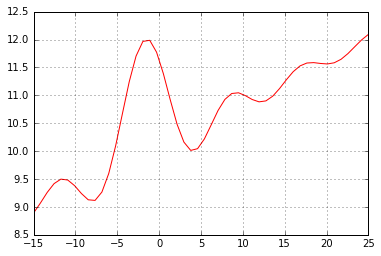

In [2]:
def f(X):
    return 10. + .1*X + 2*np.sin(X)/X

fig,ax = pb.subplots()
ax.plot(np.linspace(-15,25),f(np.linspace(-10,20)),'r-')
ax.grid()

We will draw some points $( {\bf x},y)$ from the function above, and add some noise on $y$. 

The variance of the error is designed vary randomly across the input range, where the variance is self, $\sigma_{i}^2$, is randomly generated, as such samples Y will be drawn from $y \sim \mathcal{N}(f({\bf x}),\sigma_{i}^2)$, where $\sigma_{i}^2 \sim \mathcal{N}(0, 0.2)$ and is the variance associated with the ith output $y_{i}$.

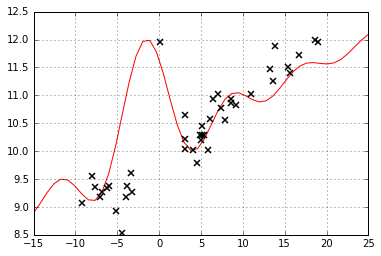

In [3]:
X = np.random.uniform(-10,20, 50)
X = X[~np.logical_and(X>-2,X<3)] #Remove points between -2 and 3 (just for illustration) 
X = np.hstack([np.random.uniform(-1,1,1),X]) #Prepend a point between -1 and 1  (just for illustration)
error = np.random.normal(0,.2,X.size)
true_f = f(X)
Y = true_f + error
fig,ax = pb.subplots()
ax.plot(np.linspace(-15,25),f(np.linspace(-10,20)),'r-')
ax.plot(X,Y,'kx',mew=1.5)
ax.grid()

We will use a combination of an MLP and Bias kernels for our Gaussian process. Although other kernels can be used as well.

In [4]:
kern = GPy.kern.MLP(1) + GPy.kern.Bias(1)

For the moment, we will assume that we already know the error on each observation (i.e. $\sigma_{i}^2$ is known for all i).
To call the model we just need to run these lines.

 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


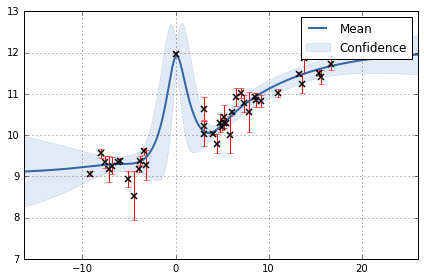

In [5]:
m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern)
m['.*het_Gauss.variance'] = abs(error)[:,None] #Set the noise parameters to the known error in Y
m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
m.optimize()

m.plot_f() #Show the predictive values of the GP.
pb.errorbar(X,Y,yerr=np.array(m.likelihood.flattened_parameters).flatten(),fmt='none',ecolor='r',zorder=1)
pb.grid()
pb.plot(X,Y,'kx',mew=1.5)

Here the error bars around each observation displays the standard error, using the known values of $\sigma_{i}^2$. As such the Gaussian process knows that for some observations (with larger variance) the latent function does not need to go almost exactly through the datapoint, and for other observations (with a small variance), the latent function must go very close to the observed value.

In the following example we show how the magnitude of the noise of a specific observation modifies the model fit. This illustrates the effects of properly specifying a model that is known to have input dependant noise (variance changing between observations), as opposed to a misspecified model where the variance is assumed to be shared.

In [6]:
modal_parameters = m[:].copy()

def noise_effect(noise):
    m[:] = modal_parameters
    m.het_Gauss.variance[:1] = noise
    m.het_Gauss.variance.fix()
    m.optimize()

    m.plot_f() 
    pb.errorbar(X.flatten(),Y.flatten(),yerr=np.array(m.likelihood.flattened_parameters).flatten(),fmt=None,ecolor='r',zorder=1)        
    pb.plot(X[1:],Y[1:],'kx',mew=1.5)
    pb.plot(X[:1],Y[:1],'ko',mew=.5)
    pb.grid()

Scroll the bar to see how the GP fitted changes.

 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2790: MatplotlibDeprecationWarning:Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.


<function __main__.noise_effect>

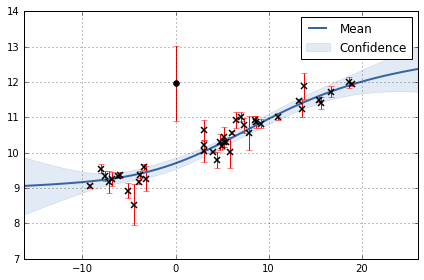

In [7]:
from IPython.html.widgets import *
interact(noise_effect, noise=(0.1,2.))

If we set all the noise terms to be equal, then we have just a homoscedastic GP regression model. The code below shows a comparison between the heteroscedastic and the homoscedastic models when the noise terms are fixed to the same value (i.e. the resulting models should be identical).

 /Users/alansaul/Work/Code/paramz/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel parameters (optimized) in the heteroscedastic model
  sum.                 |               value  |  constraints  |  priors
  mlp.variance         |       1047416.79917  |      +ve      |        
  mlp.weight_variance  |   1.68892166814e-08  |      +ve      |        
  mlp.bias_variance    |  5.56268464627e-309  |      +ve      |        
  bias.variance        |       98.3082125883  |      +ve      |        

Kernel parameters (optimized) in the homoscedastic model
  sum.                 |               value  |  constraints  |  priors
  mlp.variance         |       1047416.79917  |      +ve      |        
  mlp.weight_variance  |   1.68892166814e-08  |      +ve      |        
  mlp.bias_variance    |  5.56268464627e-309  |      +ve      |        
  bias.variance        |       98.3082125883  |      +ve      |        


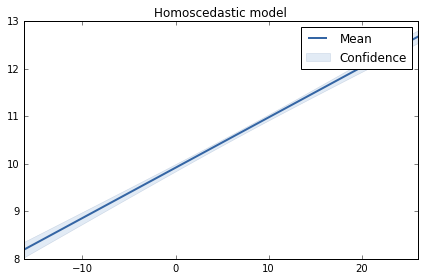

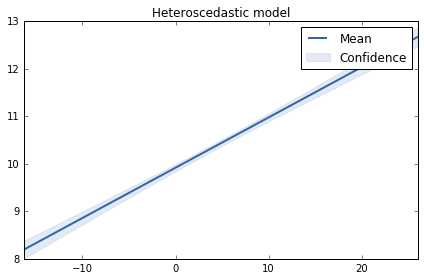

In [8]:
#Heteroscedastic model
m1 = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern)
m1.het_Gauss.variance = .05
m1.het_Gauss.variance.fix()
m1.optimize()

# Homoscedastic model
m2 = GPy.models.GPRegression(X[:,None],Y[:,None],kern)
m2['.*Gaussian_noise'] = .05
m2['.*noise'].fix()
m2.optimize()

m1.plot_f()
pb.title('Homoscedastic model')
m2.plot_f()
pb.title('Heteroscedastic model')

print "Kernel parameters (optimized) in the heteroscedastic model"
print m1.kern
print "\nKernel parameters (optimized) in the homoscedastic model"
print m2.kern

We can also learn the noise for each observation. 
In some cases we find it useful to set a lower bound on the noise terms of $10^{-6}$ or to add a white noise kernel to ensure the resulting covariance matrix is positive definite.

In [9]:
kern = GPy.kern.MLP(1) + GPy.kern.Bias(1)

In [10]:
m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern)
m.optimize()

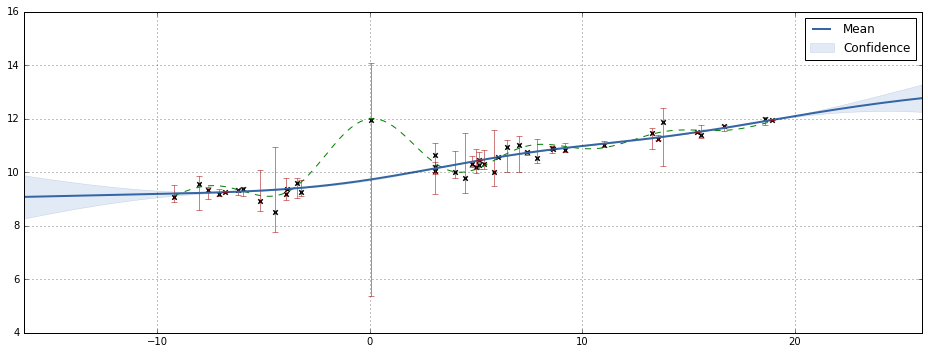

In [11]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
X_pred = np.linspace(X.min(), X.max(), 200)[:, None]
plt.plot(X_pred, f(X_pred), 'g--')
m.plot_f(ax=ax)
m.plot_data(ax=ax)
m.plot_errorbars_trainset(ax=ax, alpha=1)
fig.tight_layout()
pb.grid()

Here it is clear that the model has (incorrectly) learnt that it is more likely that the function is very smooth, and that the apperant outlier at is more easily attributed to a large noise variance at this input location. This illustrates one of the dangers of allowing such flexibility and hence when known, variances (or at least approximate variances) should be provided.

Predictions of $y$ at new points $\bf x$ would need a estimate of the noise term, however we just have those for the training set. Currently there is no routine implemented to estimate heteroscedastic noise at new points and these must be known. Estimates for the GP at new points are still available using the following command:

In [12]:
mu, var = m._raw_predict(m.X)